In [ ]:
# 기본 라이브러리
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import numpy as np

# 1. Fashion MNIST 데이터 속성 확인

Fashion MNIST
*   의류 이미지 데이터셋
*   총 10개의 클래스(티셔츠, 바지 등)

*   학습용 60,000개, 테스트용 10,000개 이미지
*   흑백 28x28 크기 이미지

Train 데이터 크기: 60000
Test 데이터 크기: 10000
이미지 배치 크기: torch.Size([64, 1, 28, 28])
레이블 배치 크기: torch.Size([64])


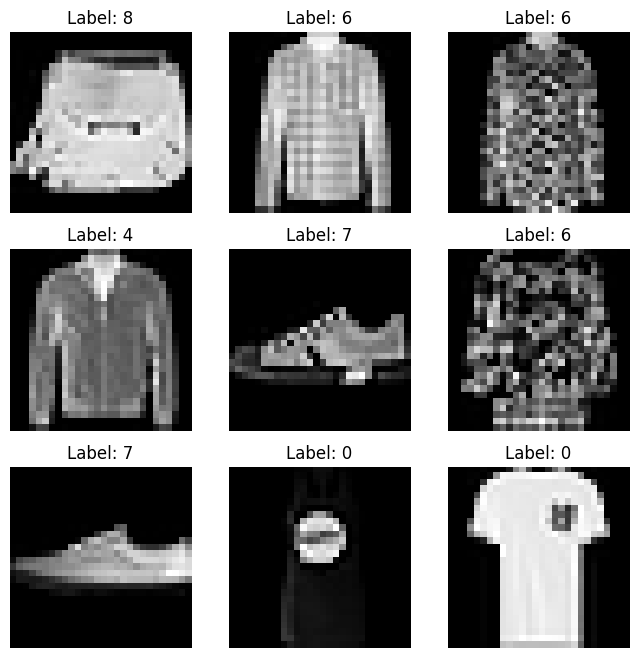

In [ ]:
# 데이터셋 다운로드 및 변환
transform = transforms.ToTensor()

train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# 데이터 로더
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# 데이터 크기 확인
print(f"Train 데이터 크기: {len(train_dataset)}")
print(f"Test 데이터 크기: {len(test_dataset)}")

# 하나의 데이터 확인
images, labels = next(iter(train_loader))
print(f"이미지 배치 크기: {images.shape}")  # (64, 1, 28, 28)
print(f"레이블 배치 크기: {labels.shape}")

# 일부 이미지 시각화
plt.figure(figsize=(8,8))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(images[i][0], cmap='gray')
    plt.title(f"Label: {labels[i].item()}")
    plt.axis('off')
plt.show()

# 2. 모델 정의

### (1) MLP 모델

In [ ]:
# 간단한 MLP 모델 정의
class SimpleMLP(nn.Module):
    def __init__(self):
        super(SimpleMLP, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)  # Flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# 모델 생성
model_mlp = SimpleMLP()

# 손실 함수와 옵티마이저 설정
criterion = nn.CrossEntropyLoss()
optimizer_mlp = optim.Adam(model_mlp.parameters(), lr=0.001)

### (2) CNN 모델

In [ ]:
# CNN 모델 정의
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)  # (28,28) -> (28,28)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1) # (28,28) -> (28,28)
        self.pool = nn.MaxPool2d(2, 2)               # (28,28) -> (14,14)
        self.fc1 = nn.Linear(64*14*14, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64*14*14)  # Flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# 모델 생성
model_cnn = SimpleCNN()

# 손실 함수와 옵티마이저 설정
optimizer_cnn = optim.Adam(model_cnn.parameters(), lr=0.001)

# 3. 모델 학습

In [ ]:
# 학습 함수
def train(model, optimizer, criterion, train_loader, device):
    model.train()
    running_loss = 0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    return running_loss / len(train_loader), correct / total

# 테스트 함수
def evaluate(model, criterion, test_loader, device):
    model.eval()
    running_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    return running_loss / len(test_loader), correct / total

# 디바이스 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_mlp.to(device)
model_cnn.to(device)

# 학습 루프
epochs = 10
mlp_train_losses, mlp_test_losses = [], []
mlp_train_accs, mlp_test_accs = [], []
cnn_train_losses, cnn_test_losses = [], []
cnn_train_accs, cnn_test_accs = [], []

print("MLP 학습")
for epoch in range(epochs):
    # MLP 학습
    train_loss, train_acc = train(model_mlp, optimizer_mlp, criterion, train_loader, device)
    test_loss, test_acc = evaluate(model_mlp, criterion, test_loader, device)
    mlp_train_losses.append(train_loss)
    mlp_test_losses.append(test_loss)
    mlp_train_accs.append(train_acc)
    mlp_test_accs.append(test_acc)
    print(f"[Epoch {epoch+1}] MLP Train Loss: {train_loss:.4f}, MLP Test Loss: {test_loss:.4f}")

for epoch in range(epochs):
    # CNN 학습
    train_loss_cnn, train_acc_cnn = train(model_cnn, optimizer_cnn, criterion, train_loader, device)
    test_loss_cnn, test_acc_cnn = evaluate(model_cnn, criterion, test_loader, device)
    cnn_train_losses.append(train_loss_cnn)
    cnn_test_losses.append(test_loss_cnn)
    cnn_train_accs.append(train_acc_cnn)
    cnn_test_accs.append(test_acc_cnn)
    print(f"[Epoch {epoch+1}] CNN Train Loss: {train_loss_cnn:.4f}, CNN Test Loss: {test_loss_cnn:.4f}")

MLP 학습
[Epoch 1] MLP Train Loss: 0.5506, MLP Test Loss: 0.4649
[Epoch 2] MLP Train Loss: 0.4016, MLP Test Loss: 0.4108
[Epoch 3] MLP Train Loss: 0.3601, MLP Test Loss: 0.3762
[Epoch 4] MLP Train Loss: 0.3306, MLP Test Loss: 0.3655
[Epoch 5] MLP Train Loss: 0.3119, MLP Test Loss: 0.3548
[Epoch 6] MLP Train Loss: 0.2983, MLP Test Loss: 0.3713
[Epoch 7] MLP Train Loss: 0.2858, MLP Test Loss: 0.3573
[Epoch 8] MLP Train Loss: 0.2740, MLP Test Loss: 0.3353
[Epoch 9] MLP Train Loss: 0.2641, MLP Test Loss: 0.3440
[Epoch 10] MLP Train Loss: 0.2565, MLP Test Loss: 0.3338
[Epoch 1] CNN Train Loss: 0.3935, CNN Test Loss: 0.3318
[Epoch 2] CNN Train Loss: 0.2459, CNN Test Loss: 0.2476
[Epoch 3] CNN Train Loss: 0.1915, CNN Test Loss: 0.2334
[Epoch 4] CNN Train Loss: 0.1525, CNN Test Loss: 0.2237
[Epoch 5] CNN Train Loss: 0.1220, CNN Test Loss: 0.2296
[Epoch 6] CNN Train Loss: 0.0915, CNN Test Loss: 0.2557
[Epoch 7] CNN Train Loss: 0.0690, CNN Test Loss: 0.2632
[Epoch 8] CNN Train Loss: 0.0492, CNN Te

# 4. 모델 평가

정확도
MLP Train Accuracy: 90.59%
MLP Test Accuracy : 88.32%
CNN Train Accuracy: 98.99%
CNN Test Accuracy : 91.73%


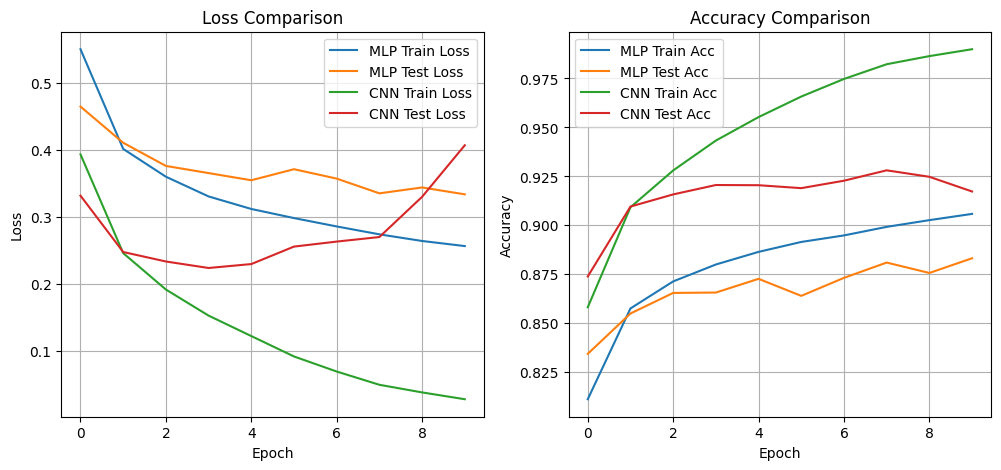

In [ ]:
# 마지막 epoch 기준 최종 정확도 출력
print(f"정확도")
print(f"MLP Train Accuracy: {mlp_train_accs[-1]*100:.2f}%")
print(f"MLP Test Accuracy : {mlp_test_accs[-1]*100:.2f}%")
print(f"CNN Train Accuracy: {cnn_train_accs[-1]*100:.2f}%")
print(f"CNN Test Accuracy : {cnn_test_accs[-1]*100:.2f}%")

# 그래프 시각화
plt.figure(figsize=(12,5))

# Loss
plt.subplot(1,2,1)
plt.plot(mlp_train_losses, label='MLP Train Loss')
plt.plot(mlp_test_losses, label='MLP Test Loss')
plt.plot(cnn_train_losses, label='CNN Train Loss')
plt.plot(cnn_test_losses, label='CNN Test Loss')
plt.title('Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Accuracy
plt.subplot(1,2,2)
plt.plot(mlp_train_accs, label='MLP Train Acc')
plt.plot(mlp_test_accs, label='MLP Test Acc')
plt.plot(cnn_train_accs, label='CNN Train Acc')
plt.plot(cnn_test_accs, label='CNN Test Acc')
plt.title('Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.show()

## 5. CNN 모델 개선

In [ ]:
class ImprovedCNN(nn.Module):
    def __init__(self):
        super(ImprovedCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)  # BatchNorm 추가
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)  # BatchNorm 추가
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.3) # Dropout 추가
        self.fc1 = nn.Linear(64*14*14, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = x.view(-1, 64*14*14)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

In [ ]:
# 모델 생성
improved_cnn = ImprovedCNN().to(device)

# 손실 함수와 옵티마이저
criterion_improved = nn.CrossEntropyLoss()
optimizer_improved = optim.Adam(improved_cnn.parameters(), lr=0.001)

# 결과 저장 리스트
improved_train_losses, improved_test_losses = [], []
improved_train_accs, improved_test_accs = [], []

for epoch in range(epochs):
    train_loss, train_acc = train(improved_cnn, optimizer_improved, criterion_improved, train_loader, device)
    test_loss, test_acc = evaluate(improved_cnn, criterion_improved, test_loader, device)

    improved_train_losses.append(train_loss)
    improved_test_losses.append(test_loss)
    improved_train_accs.append(train_acc)
    improved_test_accs.append(test_acc)

    print(f"[Improved CNN Epoch {epoch+1}] Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")

[Improved CNN Epoch 1] Train Loss: 0.4545, Test Loss: 0.3135
[Improved CNN Epoch 2] Train Loss: 0.3035, Test Loss: 0.2908
[Improved CNN Epoch 3] Train Loss: 0.2520, Test Loss: 0.2410
[Improved CNN Epoch 4] Train Loss: 0.2182, Test Loss: 0.2337
[Improved CNN Epoch 5] Train Loss: 0.1920, Test Loss: 0.2424
[Improved CNN Epoch 6] Train Loss: 0.1680, Test Loss: 0.2167
[Improved CNN Epoch 7] Train Loss: 0.1508, Test Loss: 0.2167
[Improved CNN Epoch 8] Train Loss: 0.1308, Test Loss: 0.2332
[Improved CNN Epoch 9] Train Loss: 0.1157, Test Loss: 0.2390
[Improved CNN Epoch 10] Train Loss: 0.1042, Test Loss: 0.2516


Original CNN Train Accuracy: 98.99%
Original CNN Test Accuracy : 91.73%
Improved CNN Train Accuracy: 96.10%
Improved CNN Test Accuracy : 92.63%


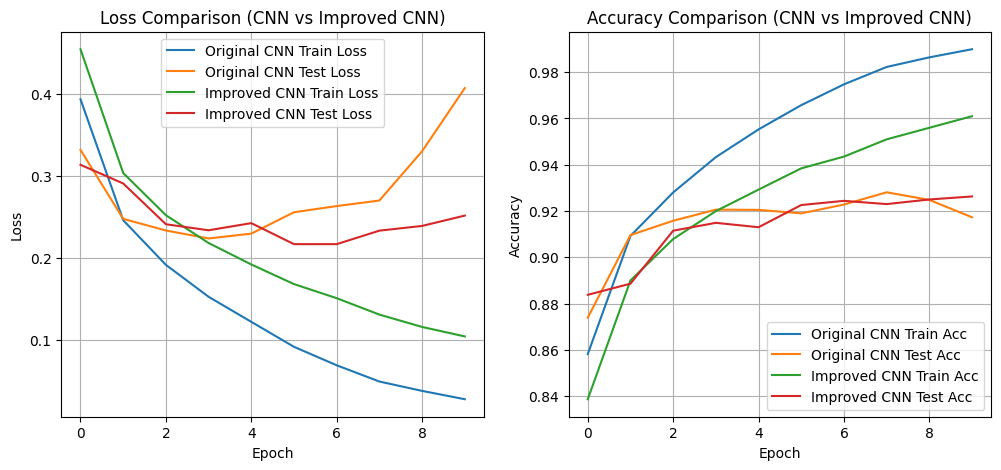

In [ ]:
print(f"Original CNN Train Accuracy: {cnn_train_accs[-1]*100:.2f}%")
print(f"Original CNN Test Accuracy : {cnn_test_accs[-1]*100:.2f}%")
print(f"Improved CNN Train Accuracy: {improved_train_accs[-1]*100:.2f}%")
print(f"Improved CNN Test Accuracy : {improved_test_accs[-1]*100:.2f}%")

plt.figure(figsize=(12,5))

# Loss 비교
plt.subplot(1,2,1)
plt.plot(cnn_train_losses, label='Original CNN Train Loss')
plt.plot(cnn_test_losses, label='Original CNN Test Loss')
plt.plot(improved_train_losses, label='Improved CNN Train Loss')
plt.plot(improved_test_losses, label='Improved CNN Test Loss')
plt.title('Loss Comparison (CNN vs Improved CNN)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Accuracy 비교
plt.subplot(1,2,2)
plt.plot(cnn_train_accs, label='Original CNN Train Acc')
plt.plot(cnn_test_accs, label='Original CNN Test Acc')
plt.plot(improved_train_accs, label='Improved CNN Train Acc')
plt.plot(improved_test_accs, label='Improved CNN Test Acc')
plt.title('Accuracy Comparison (CNN vs Improved CNN)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 개선된 CNN 모델
class EnhancedCNN(nn.Module):
    def __init__(self):
        super(EnhancedCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)  # 추가
        self.bn3 = nn.BatchNorm2d(128)

        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.3)
        self.fc1 = nn.Linear(128 * 7 * 7, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))  # conv3 + pool
        x = x.view(-1, 128 * 7 * 7)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

# 모델, 손실함수, 옵티마이저 준비
enhanced_model = EnhancedCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(enhanced_model.parameters(), lr=0.001)

# 학습률 스케줄러
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)

# Early Stopping 변수
best_loss = float('inf')
patience = 5
trigger_times = 0

epochs = 30
enhanced_train_losses, enhanced_test_losses = [], []
enhanced_train_accs, enhanced_test_accs = [], []

for epoch in range(epochs):
    enhanced_model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = enhanced_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = correct / total

    enhanced_train_losses.append(train_loss)
    enhanced_train_accs.append(train_acc)

    # 평가
    enhanced_model.eval()
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = enhanced_model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_loss /= len(test_loader)
    test_acc = correct / total

    enhanced_test_losses.append(test_loss)
    enhanced_test_accs.append(test_acc)

    # 출력
    print(f"[Epoch {epoch+1}] Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

    # 학습률 스케줄링
    scheduler.step()

    # Early Stopping 체크
    if test_loss < best_loss:
        best_loss = test_loss
        trigger_times = 0
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print("Early stopping triggered!")
            break


[Epoch 1] Train Loss: 0.4204, Train Acc: 0.8483, Test Loss: 0.3009, Test Acc: 0.8887
[Epoch 2] Train Loss: 0.2738, Train Acc: 0.8999, Test Loss: 0.2512, Test Acc: 0.9048
[Epoch 3] Train Loss: 0.2294, Train Acc: 0.9161, Test Loss: 0.2505, Test Acc: 0.9120
[Epoch 4] Train Loss: 0.1723, Train Acc: 0.9365, Test Loss: 0.1924, Test Acc: 0.9297
[Epoch 5] Train Loss: 0.1514, Train Acc: 0.9440, Test Loss: 0.1937, Test Acc: 0.9319
[Epoch 6] Train Loss: 0.1314, Train Acc: 0.9517, Test Loss: 0.1980, Test Acc: 0.9344
[Epoch 7] Train Loss: 0.1004, Train Acc: 0.9631, Test Loss: 0.1887, Test Acc: 0.9352
[Epoch 8] Train Loss: 0.0860, Train Acc: 0.9680, Test Loss: 0.2096, Test Acc: 0.9332
[Epoch 9] Train Loss: 0.0743, Train Acc: 0.9727, Test Loss: 0.2012, Test Acc: 0.9356
[Epoch 10] Train Loss: 0.0558, Train Acc: 0.9801, Test Loss: 0.2108, Test Acc: 0.9400
[Epoch 11] Train Loss: 0.0482, Train Acc: 0.9830, Test Loss: 0.2195, Test Acc: 0.9392
[Epoch 12] Train Loss: 0.0445, Train Acc: 0.9845, Test Loss: 0.

Test Accuracy : 93.93%


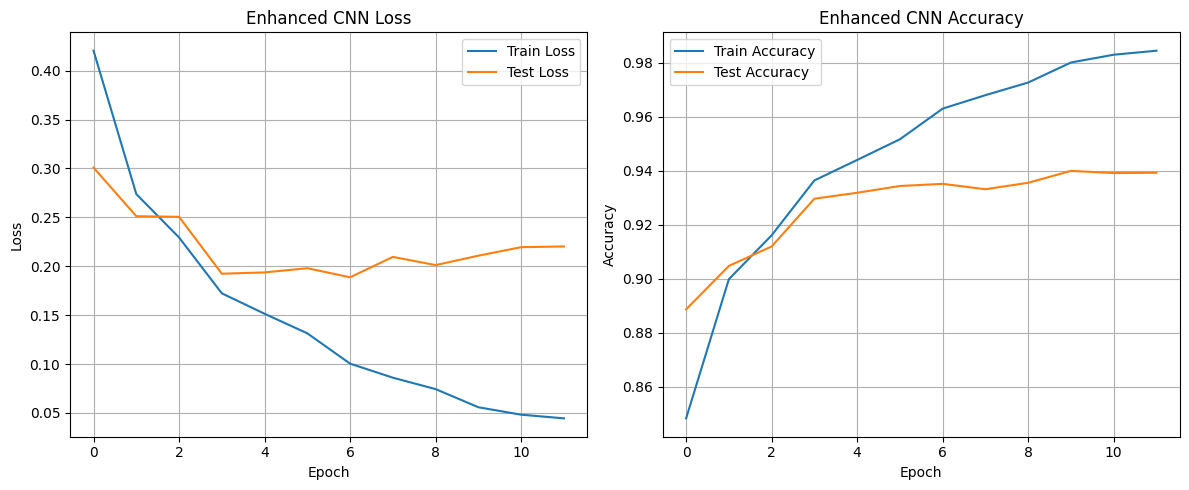

In [ ]:
print(f"Test Accuracy : {enhanced_test_accs[-1]*100:.2f}%")

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Loss 시각화
plt.subplot(1, 2, 1)
plt.plot(enhanced_train_losses, label='Train Loss')
plt.plot(enhanced_test_losses, label='Test Loss')
plt.title('Enhanced CNN Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Accuracy 시각화
plt.subplot(1, 2, 2)
plt.plot(enhanced_train_accs, label='Train Accuracy')
plt.plot(enhanced_test_accs, label='Test Accuracy')
plt.title('Enhanced CNN Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

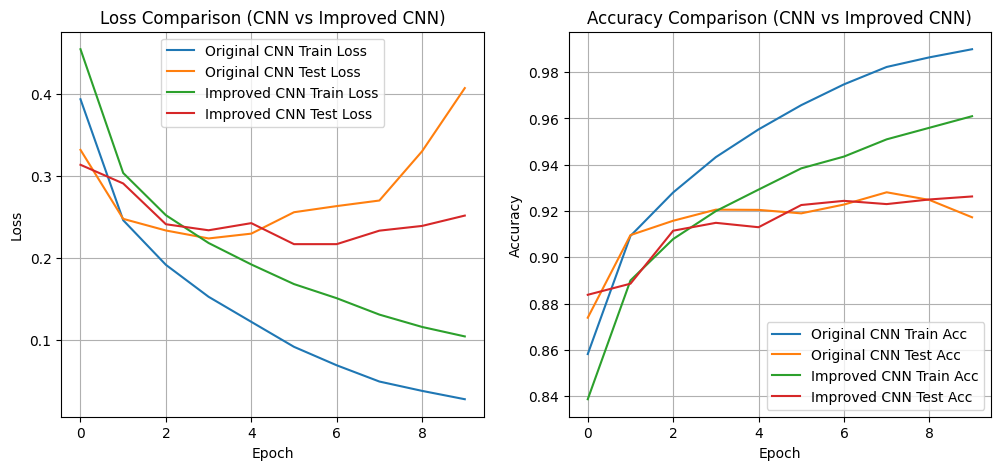

In [ ]:
print(f"Original CNN Test Accuracy : {cnn_test_accs[-1]*100:.2f}%")
print(f"Improved CNN Test Accuracy : {improved_test_accs[-1]*100:.2f}%")
print(f"Enhanced CNN Test Accuracy : {enhanced_test_accs[-1]*100:.2f}%")

Original CNN Test Accuracy : 91.73%
Improved CNN Test Accuracy : 92.63%
Enhanced CNN Test Accuracy : 93.93%
